# Estimating consumer lifetime value (CLV)

In [1]:
# importing libraries
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
churn = pd.read_csv("../data/df_from_eng.csv")

In [3]:
churn.head(3)

,player_id_cat,gender,vertical,date,day_of_week,day_of_month,month,week_of_year,deposit_approved_sum,withdrawal_approved_sum,turnover_cash_sum,winning_cash_sum,result_cash_sum,NGR_sum,bonus_cash_sum,session_sum
0,1,female,casino_classic,2013-01-29,1,29,1,5,0,0,73,43,-30,30,0,2313
1,1,female,casino_classic,2013-02-07,3,7,2,6,0,0,0,0,0,0,0,6007
2,1,female,casino_classic,2013-02-18,0,18,2,8,0,0,0,0,0,0,0,3601


The CLV will be estimating using the library `lifetimes`.

In [52]:
import lifetimes

from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

from lifetimes.plotting import *
from lifetimes.utils import *

from lifetimes import BetaGeoFitter

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive

from lifetimes.utils import calibration_and_holdout_data
from lifetimes import GammaGammaFitter

In [5]:
print(f"lifetimes version: {lifetimes.__version__}")

lifetimes version: 0.11.3


In [6]:
# churn_lifetimes = churn[["player_id_cat", "date", "result_cash_sum"]]
# df2 = df.rename({'a': 'X', 'b': 'Y'}, axis=1)
# churn_lifetimes = churn_lifetimes.rename(
#    {
#        "player_id": "frequency",
#        "date": "T",
#        "result_cash_sum": "recency"
#    },
#    axis=1,
# )
# churn_lifetimes.tail()

In [7]:
data = summary_data_from_transaction_data(
    churn,
    "player_id_cat",
    "date",
    monetary_value_col="session_sum",
    # monetary_valeu_col='result_cash_sum',
    observation_period_end="2013-12-31",
)
data.head()

,frequency,recency,T,monetary_value
player_id_cat,,,,
1,32.0,323.0,336.0,2484.56250
2,23.0,317.0,321.0,1079.73913
4,0.0,0.0,273.0,0.00000
8,0.0,0.0,99.0,0.00000
9,5.0,60.0,126.0,3818.60000


In [8]:
data.frequency.value_counts().max()

2686


count    9027.000000
mean       11.501496
std        27.217690
min         0.000000
25%         0.000000
50%         2.000000
75%         9.000000
max       300.000000
Name: frequency, dtype: float64

0.2975517890772128



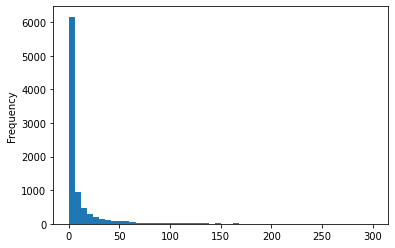

In [9]:
data["frequency"].plot(kind="hist", bins=50)
print()
print(data["frequency"].describe())
print()
print(sum(data["frequency"] == 0) / float(len(data)))
print()

In [10]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data["frequency"], data["recency"], data["T"])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 9027 subjects, a: 0.37, alpha: 1.83, b: 1.99, r: 0.33>


In [11]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.325512,0.005300,0.315124,0.335901
alpha,1.829328,0.051551,1.728288,1.930369
a,0.365186,0.012250,0.341176,0.389197
b,1.992529,0.112717,1.771603,2.213455


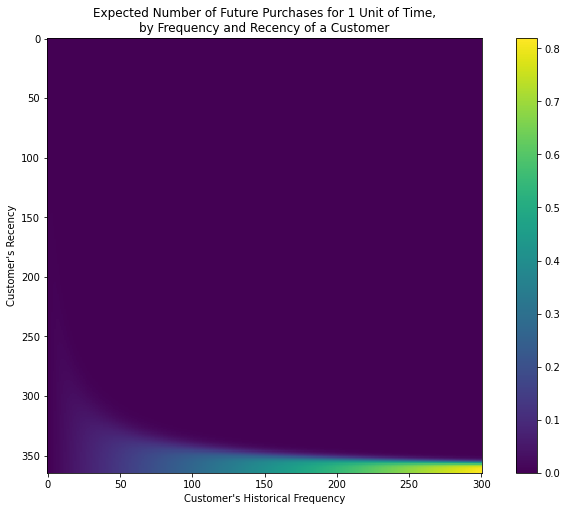

In [15]:
plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(bgf, max_frequency=300)
plt.show()
plt.close()

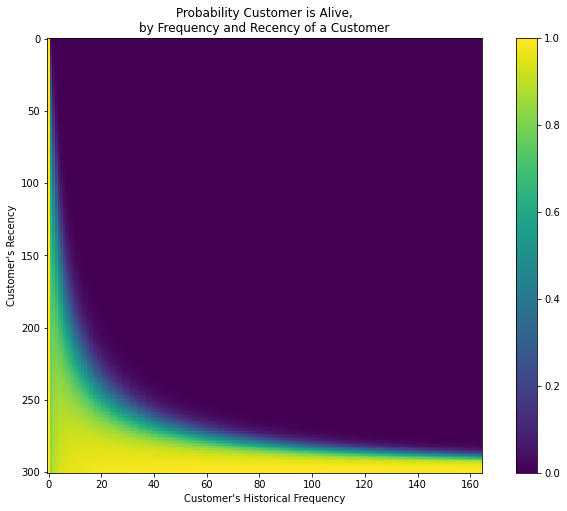

In [19]:
plt.subplots(figsize=(12, 8))
plot_probability_alive_matrix(bgf, max_frequency=164, max_recency=300)
plt.show()
plt.close()

In [20]:
t = 1
data["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, data["frequency"], data["recency"], data["T"]
)
data.sort_values(by="predicted_purchases").tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
player_id_cat,,,,,
8766,23.0,23.0,23.0,24175.478261,0.918934
1909,69.0,71.0,72.0,18827.855072,0.924309
9786,300.0,317.0,317.0,1211.666667,0.940286
5563,179.0,185.0,185.0,18315.804469,0.956964
6902,74.0,75.0,75.0,19676.459459,0.960479


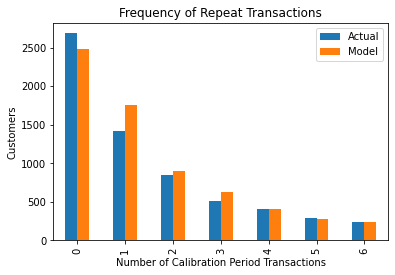

In [22]:
plot_period_transactions(bgf)
plt.show()
plt.close()

In [24]:
# plot_incremental_transactions(bgf)

In [28]:
summary_cal_holdout = calibration_and_holdout_data(
    churn,
    "player_id_cat",
    "date",
    calibration_period_end="2013-01-31",
    observation_period_end="2013-12-31",
)
print(summary_cal_holdout.head())

               frequency_cal  recency_cal  T_cal  frequency_holdout  \
player_id_cat                                                         
1                        0.0          0.0    2.0               32.0   
32                       0.0          0.0    2.0                0.0   
47                       0.0          0.0    0.0                1.0   
71                       1.0          2.0   24.0                0.0   
76                       0.0          0.0    0.0                0.0   

               duration_holdout  
player_id_cat                    
1                         334.0  
32                        334.0  
47                        334.0  
71                        334.0  
76                        334.0  


/home/smv/anaconda3/envs/churn_lv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


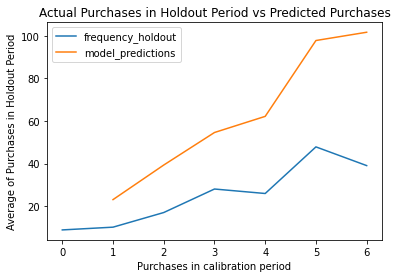

In [30]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(
    summary_cal_holdout["frequency_cal"],
    summary_cal_holdout["recency_cal"],
    summary_cal_holdout["T_cal"],
)
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show()
plt.close()

In [35]:
t = 10
individual = data.loc[1]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.9498897746397659

ConversionError: Failed to convert value(s) to axis units: '2013-01-29'

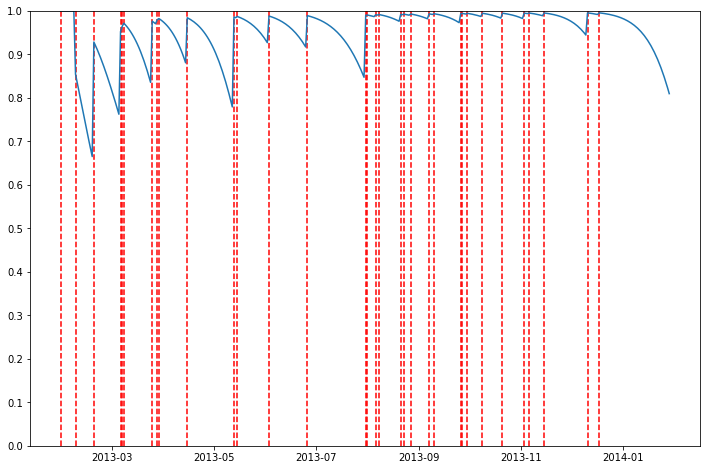

In [45]:
plt.figure(figsize=(12,8))
id = 1
days_since_birth = 365
sp_trans = churn.loc[churn['player_id_cat'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.show()
plot.close()

ConversionError: Failed to convert value(s) to axis units: '2013-02-15'

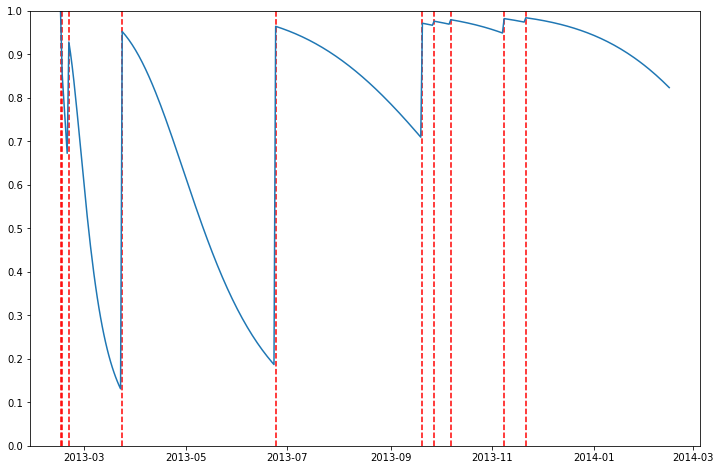

In [48]:
fig = plt.figure(figsize=(12,8))
id = 1100
days_since_birth = 365
sp_trans = churn.loc[churn['player_id_cat'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.show()
plt.close()

In [51]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

               frequency  recency      T  monetary_value  predicted_purchases
player_id_cat                                                                
1                   32.0    323.0  336.0      2484.56250             0.092015
2                   23.0    317.0  321.0      1079.73913             0.070773
9                    5.0     60.0  126.0      3818.60000             0.010626
10                   1.0     48.0   84.0      1917.00000             0.011200
12                   1.0      1.0  331.0      7496.00000             0.000039
6341


In [55]:
ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

ValueError: There exist non-positive (<= 0) values in the monetary_value vector.